[Kaggle-соревнование](https://www.kaggle.com/c/simpsons3 (Ссылки на внешний сайт.)) **в рамках курса "Deep Learning" от МФТИ.**

**Необходимо обучить классификатор отличать всех жителей Спрингфилда**


### Загружаем датасеты в Google Colab

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is NOT available')
else:
    print('CUDA is available')

CUDA is available


In [2]:
import PIL
print(PIL.PILLOW_VERSION)

4.3.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/simpsons

simple_cnn_baseline.csv  testset.zip  train.zip


In [0]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/simpsons/train.zip -d train
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/simpsons/testset.zip -d test

In [6]:
!ls

gdrive	sample_data  test  train


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu May 16 09:36:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    17W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В тестовом датасете 990 картнок, для которых необходимо предсказать класс

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Ниже мы исспользуем враппер над датасетом для удобной работы.

Ещё переопределим метод __getitem__ для удобства работы с данной структурой данных.

Используем LabelEncoder для преобразования строковых меток классов в id и обратно.

В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следует привести их к одному размеру (это делает метод  *_prepare_sample*) 

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который подгружает их из папок,
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) #список файлов для загрузки
        self.mode = mode #режим работы

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as dump_file:
                pickle.dump(self.label_encoder, dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)
  
    def __getitem__(self, index):
        # преобразование изображений в тензоры PyTorch и нормализация входа
        # (средние и дисперсии по каналам взяты на основе ImageNet)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
        if self.mode == 'test':
            return x
          
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [0]:
TRAIN_DIR = Path('train/train/simpsons_dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

Посмотрим, как выглядят подготовленные для нейросети картинки

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

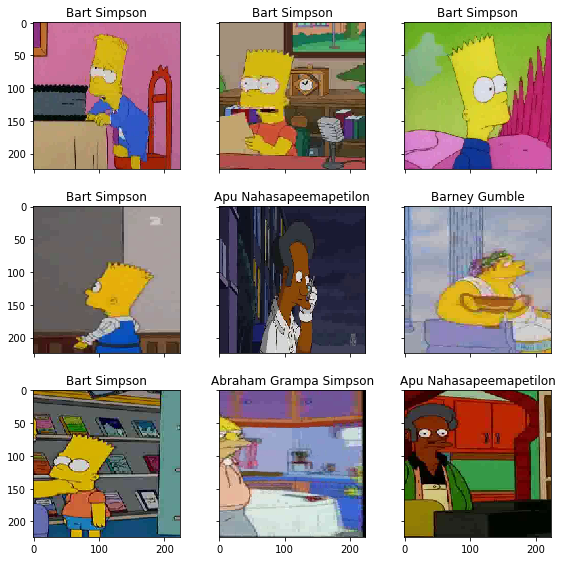

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

fig, ax = plt.subplots(3, 3, figsize=(8,8), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
plt.tight_layout();

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

## Построение моделей

Для классификации картинок применим технику Transfer Learning. Дообучать будем две сети: VGG16 и ResNet

**Основные данные**

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

In [0]:
# Количество классов, которые нужно предсказать
n_classes = len(np.unique(train_val_labels))
print('total classes: {}'.format(n_classes))

total classes: 42


In [0]:
# Тренировочный и валидационный датасеты   
train_dataset = SimpsonsDataset(train_files, mode='train')

if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

**Тренировка моделей**

Напишем две отдельные функции для обучения и валидации сети

In [0]:
# Обучение сети
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
     
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [0]:
# Валидация сети
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    
    return val_loss, val_acc

Теперь напишем функцию для тренировки (fit + eval)

In [0]:
# Тренировка сети
def train(model, train_files, val_files, criterion, optimizer, scheduler, epochs, batch_size):
  
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

### Feature Extractor

In [0]:
# Берём модуль features extractor сети-донора и прикручиваем свой классификатор
def features_extractor_nn(model_extractor, classifier, fc_layer_name='classifier'):

    for param in model_extractor.parameters():
        param.requires_grad = False
    
    # добавляем свой классификатор
    if fc_layer_name == 'classifier':
      model_extractor.classifier = classifier
    
    elif fc_layer_name == 'fc':
      model_extractor.fc = classifier
    
    print(model_extractor)
    return model_extractor.to(DEVICE)

In [0]:
# График кривых обучения
def history_plot(loss, acc, val_loss, val_acc):
  
    fig, ax = plt.subplots(1, 2, figsize=(17, 5))
    ax[0].plot(loss, label="train")
    ax[0].plot(val_loss, label="valid")
    ax[0].set_title('Loss')
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")

    ax[1].plot(acc, label="train")
    ax[1].plot(val_acc, label="valid")
    ax[1].set_title('Accuracy')
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy");

#### VGG16

In [0]:
#models.vgg16(pretrained=True)

In [0]:
# Custom-классификатор
classifier_vgg16 = nn.Sequential(
      nn.Linear(in_features=25088, out_features=8192, bias=True),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=8192, out_features=4096, bias=True),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=4096, out_features=1000, bias=True),
      nn.ReLU(),
      nn.Linear(in_features=1000, out_features=250, bias=True),
      nn.ReLU(),
      nn.Linear(in_features=250, out_features=n_classes, bias=True)
  )

In [0]:
model_vgg16_extractor = features_extractor_nn(models.vgg16(pretrained=True), classifier_vgg16)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16_extractor.classifier.parameters(), lr=0.001)

# Умножаем learning_rate на 0.1 каждые 6 эпох
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [0]:
history_vgg16_extractor = train(model_extractor_vgg16,
                                train_dataset,
                                val_dataset,
                                criterion,
                                optimizer,
                                scheduler,
                                epochs=18,
                                batch_size=16)

In [0]:
loss_vgg16_extractor,\
acc_vgg16_extractor,\
val_loss_vgg16_extractor,\
val_acc_vgg16_extractor = zip(*history_vgg16_extractor)

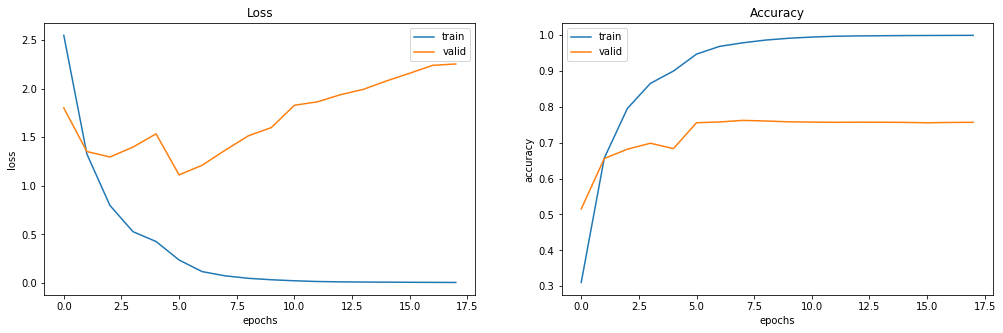

In [0]:
history_plot(loss_vgg16_extractor,
             acc_vgg16_extractor,
             val_loss_vgg16_extractor,
             val_acc_vgg16_extractor)

На графиках отчётливо видно, что сеть VGG16-future extractor переобучается

#### ResNet

In [0]:
#models.resnet50(pretrained=True)

In [0]:
# Custom-классификатор
classifier_resnet50 = nn.Sequential(
      nn.Linear(in_features=2048, out_features=1024, bias=True),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=1024, out_features=256, bias=True),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(in_features=256, out_features=n_classes, bias=True)
)

In [0]:
model_resnet50_extractor = features_extractor_nn(models.resnet50(pretrained=True), classifier_resnet50, fc_layer_name='fc')

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50_extractor.fc.parameters(), lr=0.001)

# Умножаем learning_rate на 0.1 каждые 6 эпох
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

In [0]:
history_resnet50_extractor = train(model_resnet50_extractor,
                                   train_dataset,
                                   val_dataset,
                                   criterion,
                                   optimizer,
                                   scheduler,
                                   epochs=18,
                                   batch_size=12)

In [0]:
loss_resnet50_extractor,\
acc_resnet50_extractor,\
val_loss_resnet50_extractor,\
val_acc_resnet50_extractor = zip(*history_resnet50_extractor)

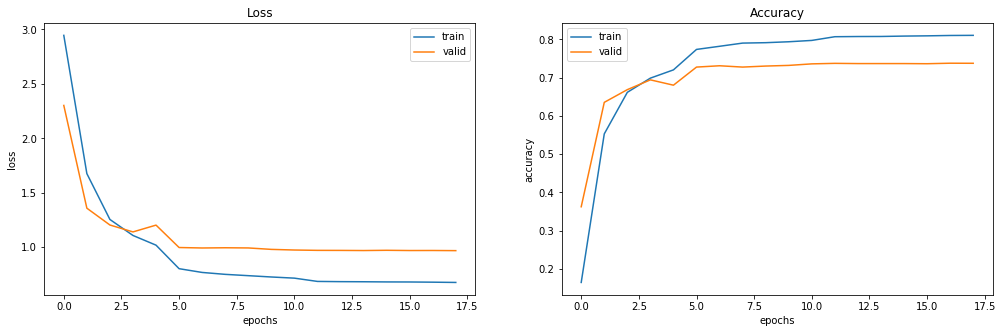

In [0]:
history_plot(loss_resnet50_extractor,
             acc_resnet50_extractor,
             val_loss_resnet50_extractor,
             val_acc_resnet50_extractor)

Сеть ResNet50-future extractor показывает немного меньшую точность, но при этом имеет достаточно хорошую обобщающую способность, т.е. не переобучается

Здесь в качестве классификатора было использовано несколько FC-слоёв. Я предварительно протестировал несколько вариантов classifier и убедился, что для выбранных архитектур сетей лучший результат даёт classifier из одного output layer. Поэтому в разделе Fine Tuning будет использоваться именно он.

## Fine tuning

#### VGG16

In [0]:
# Размораживаем несколько слоёв сети-донора и прикручиваем свой классификатор
def tune_nn(model_tune, classifier, layers_to_unfreeze):

    for param in model_tune.features[: -layers_to_unfreeze].parameters():
      param.requires_grad = False
    
    # добавляем свой классификатор
    model_tune.classifier = classifier
    print(model_tune)
    
    return model_tune.to(DEVICE)

In [0]:
# Custom-классификатор
classifier_vgg16 = nn.Linear(in_features=25088, out_features=n_classes, bias=True)

In [0]:
model_vgg16_tune = tune_nn(models.vgg16(pretrained=True), classifier_vgg16, layers_to_unfreeze=5)

In [0]:
optimizer = optim.Adam(list(model_vgg16_tune.features.parameters())[-layers_to_unfreeze : ] +
                       list(model_vgg16_tune.classifier.parameters()), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [0]:
history_vgg16_tune = train(model_vgg16_tune,
                           train_dataset,
                           val_dataset,
                           criterion,
                           optimizer,
                           scheduler,
                           epochs=10,
                           batch_size=16)

In [0]:
loss_vgg16_tune,\
acc_vgg16_tune,\
val_loss_vgg16_tune,\
val_acc_vgg16_tune = zip(*history_vgg16_tune)

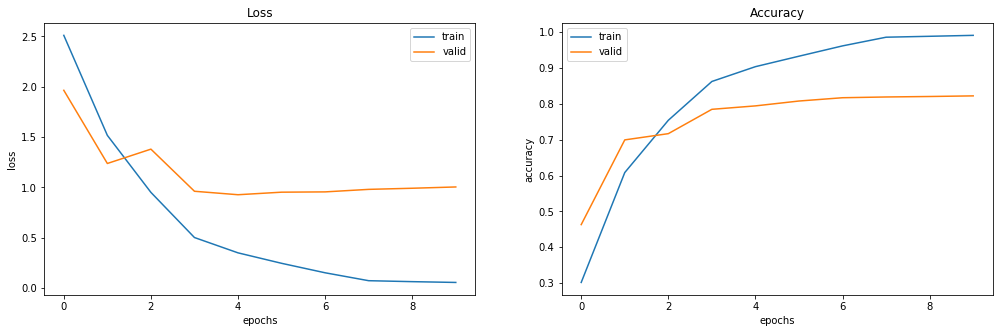

In [0]:
history_plot(loss_vgg16_tune,
             acc_vgg16_tune,
             val_loss_vgg16_tune,
             val_acc_vgg16_tune)

#### ResNet

In [0]:
classifier_resnet50 = nn.Linear(in_features=2048, out_features=n_classes, bias=True)

In [0]:
model_resnet50_tune = models.resnet50(pretrained=True)
model_resnet50_tune.fc = classifier_resnet50

In [0]:
# Размораживаем несколько слоёв сети-донора и прикручиваем свой классификатор
layers_to_unfreeze = 7

ct = 0
for name, child in model_resnet50_tune.named_children():
    ct += 1
    if ct < 7:
      for name2, params in child.named_parameters():
        params.requires_grad = False
        
model_resnet50_tune.to(DEVICE)

In [0]:
optimizer = optim.Adam(list(model_resnet50_tune.parameters())[-7 : ] +
                       list(model_resnet50_tune.fc.parameters()), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [0]:
history_resnet50_tune = train(model_resnet50_tune,
                              train_dataset,
                              val_dataset,
                              criterion,
                              optimizer,
                              scheduler,
                              epochs=8,
                              batch_size=16)

In [0]:
loss_resnet50_tune,\
acc_resnet50_tune,\
val_loss_resnet50_tune,\
val_acc_resnet50_tune = zip(*history_resnet50_tune)

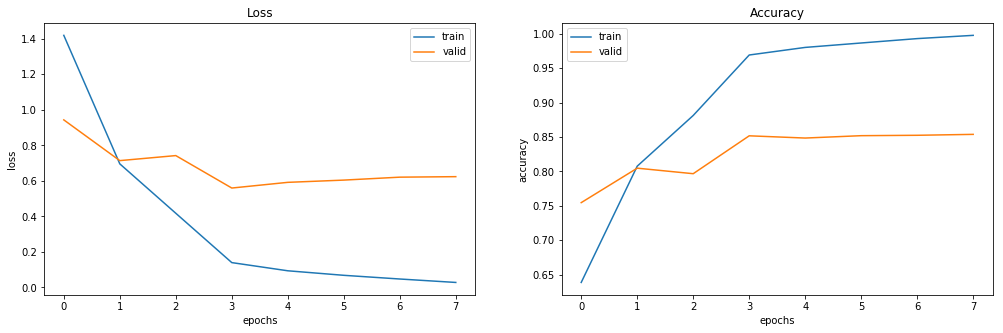

In [0]:
history_plot(loss_resnet50_tune,
             acc_resnet50_tune,
             val_loss_resnet50_tune,
             val_acc_resnet50_tune)

Видим, что лучшая точность у ResNet50, но, при этом, она переобучается - так же как и VGG16.

Что в этом случае делать?
1. Нужно построить графики Loss не только для каждой эпохи, ни и каждого батча. Так мы сможем понять, какова дисперсия ошибок на батчах, и по "ширине" кривой Loss подобрать оптимальный batch-size
2. Посмотреть результат для разных "глубин разморозки" слоёв
3. Augmentations
3. Использовать регуляризацию
4. Попробовать другие модели

Так как этот ноутбук создан с целью демонстрации навыков работы в PyTorch, я пропущу эти пункты и натренирую ResNet50 с 7-ю размороженными слоями на test+val датасетах в 4 эпохи.

## File to submit

In [0]:
import pandas as pd

In [0]:
# тренировка лучшей модели
def train_best_model(model, train_val_files, criterion, optimizer, scheduler, epochs, batch_size, PATH):
    
    train_val_dataset = SimpsonsDataset(train_val_files, mode="train")
    train_loader = DataLoader(train_val_files, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        scheduler.step()
            
      for inputs, labels in train_loader:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
    
    torch.save(model.state_dict(), PATH)      
    model.load_state_dict(torch.load(PATH))
    
    return model.eval()

In [0]:
# запись результатов в файл
def submit_file(model, test_files):
    
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)
    
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
    #print(my_submit.head())
       
    return my_submit

Собираем выбранную модель

In [0]:
model_resnet50_tune = models.resnet50(pretrained=True)
model_resnet50_tune.fc = classifier_resnet50

# Размораживаем несколько слоёв сети-донора и прикручиваем свой классификатор
layers_to_unfreeze = 7

ct = 0
for name, child in model_resnet50_tune.named_children():
    ct += 1
    if ct < 7:
      for name2, params in child.named_parameters():
        params.requires_grad = False
        
model_resnet50_tune.to(DEVICE)

optimizer = optim.Adam(list(model_resnet50_tune.parameters())[-7 : ] +
                       list(model_resnet50_tune.fc.parameters()), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Тренируем модель, затем предсказываем и сохраняем результат

In [0]:
model = train_best_model(model_resnet50_tune,
                         train_val_files,
                         criterion,
                         optimizer,
                         scheduler,
                         epochs=4,
                         batch_size=16,
                         PATH)


result = submit_file(model, test_files)
result.to_csv(PATH_TO_SUB_FILE, index=False)